In [1]:
from simulator.rl import RL, ActionSpace
from simulator.rl_wrapper import CentralizedAggregatedSim
from simulator.simulator import Simulator
from simulator.fast_simulator import FastSimulator
from simulator.constants import *
import matplotlib
import matplotlib.pyplot as plt
import torch
import pickle as pkl
#import torch.nn as nn
#import torch.optim as optim
#import torch.nn.functional as F
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [2]:
def plot_durations(rl_rsts, show_result=False):
    plt.figure(1)
    #durations_t = torch.tensor(episodes, dtype=torch.float)
    if not show_result:
        plt.clf()
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Daily Cummulative Reward', fontsize=14)
    plt.plot(rl_rsts)
    plt.legend(["Score", "Comfort score", "Energy score"])
    #plt.ylim((0, 18))

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def save(rl_model, rl_rsts, path):
    with open(f"{path}_model.pkl", "wb") as f:
        pkl.dump(rl_model, f)
    with open(f"{path}_convergence_plot.pkl", "wb") as f:
        pkl.dump(rl_rsts, f)

def run(alpha, beta, path):
    rl_rsts = []
    action_space = ActionSpace()
    interval = 30
    suffix = ""
    centralized_agg_sim = CentralizedAggregatedSim(FastSimulator(interval=interval, suffix=suffix), alpha=alpha, beta=beta)
    print(centralized_agg_sim)
    
    centralized_agg_sim.step()
    # Get number of actions from gym action space
    n_actions = action_space.n
    # Get the number of state observations
    state = centralized_agg_sim.get_states()
    n_observations = len(state)
    print(n_actions, n_observations)
    rl_model = RL(n_observations, n_actions, action_space, model_complexity=256, lr_=5e-6, batch_size_=128)

    for i_episode in range(400):
        daily_score = []
        daily_comfort_score = []
        daily_energy_score = []
        # reset simulator
        sim = CentralizedAggregatedSim(FastSimulator(interval=interval, suffix=suffix), alpha=alpha, beta=beta)
        # initialize simulator
        sim.step()
        state = sim.get_states()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        actions = []
        for i in range(19):
            # time=t: state, reward
            action = rl_model.select_action(state)
            # at time=t+1
            rl_temp = action_space.convert(action.item())
            sim.apply_action(rl_temp)
            actions.append(rl_temp)
            sim.step()
            next_state = sim.get_states()
            next_reward = sim.get_reward()
            next_state = rl_model.step(action, state, next_state, next_reward)
            state = next_state

            
            score, comfort_score, energy_score = sim.get_score()
            daily_score.append(score)
            daily_comfort_score.append(comfort_score)
            daily_energy_score.append(energy_score)
        #print(actions)
        #print(daily_cummulative_rwd, sum(daily_cummulative_rwd))
        rl_rsts.append([sum(daily_score), sum(daily_comfort_score), sum(daily_energy_score)])
        if i_episode % 50 == 0:
            print("actions", actions)
            plot_durations(rl_rsts)
            
    print('Complete')
    plot_durations(rl_rsts, show_result=True)
    plt.ioff()
    plt.show()
    
    save(rl_model, rl_rsts, path=path)
    return rl_model, rl_rsts

Complete


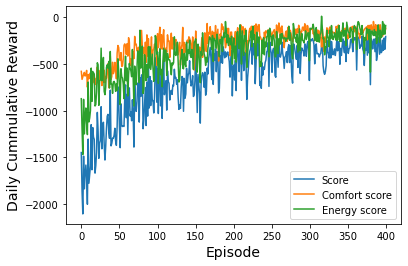

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [4]:
path=f"saved_models/centralized_control_ori"
model, rsts = run(alpha=ALPHA_, beta=BETA_, path=path)

Complete


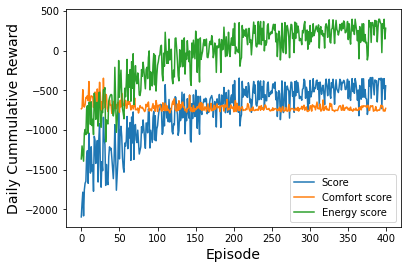

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [5]:
path=f"saved_models/centralized_control_alpha0"
model, rsts = run(alpha=0, beta=BETA_, path=path)

Complete


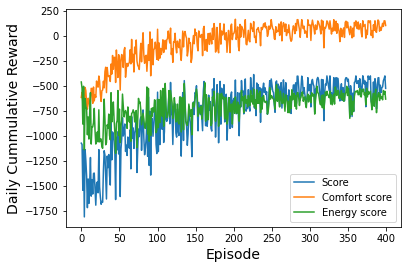

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [7]:
path=f"saved_models/centralized_control_beta0"
model, rsts = run(alpha=ALPHA_, beta=0, path=path)